# Differential Learning in TensorFlow 2
This notebook implements the paper [*Differential Machine Learning*](https://arxiv.org/abs/2005.02347) by Brian Huge and Antoine Savine. The authors already provide notebooks [on their github page](https://github.com/differential-machine-learning) but using TensorFlow 1 code, and lots of low-level manual implementation. Here we aim to reproduce the results with high-level APIs (Keras, GradientTape) in TensorFlow 2. We will use the notations from the authors' notebook as much as possible to allow for easy comparison.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pmdanton/differential_learning/blob/master/differential_machine_learning.ipynb)

# Imports

In [1]:
import tensorflow as tf
print("Using TensorFlow version", tf.__version__)

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import time

Using TensorFlow version 2.2.0


# Part I: Core Functions

## Feedforward neural network in TensorFlow
Feedforward networks are easily defined in Keras with the [Sequential API](https://www.tensorflow.org/guide/keras/overview#sequential_model), we just write a wrapper for convenience. 
The rest of the implementation (TwinNetwork) allows far more generic networks: any Keras model, of any input/output shapes.

In [2]:
def vanilla_net(input_dim, hidden_units, hidden_layers, output_dim=1):        
    net = tf.keras.Sequential()
    net.add(Input((input_dim,)))
    for _ in range(hidden_layers):
        net.add(Dense(hidden_units, activation="softplus"))
    net.add(Dense(output_dim))
    return net

## Explicit backpropagation and twin network
We will use the [Keras subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models#the_model_class) to define twin networks: given any "vanilla" network, its twin version will also return the sensitivities to inputs by AAD. 
In TensorFlow 2, getting the gradients is achieved using [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape). 
As we can see, it doesn't take much code and greatly reduces the risk of errors!

In [3]:
class TwinNetwork(tf.keras.Model):

    def __init__(self, vanilla_net):
        super(TwinNetwork, self).__init__()
        self.vanilla_net = vanilla_net

    def call(self, inputs):
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predictions = self.vanilla_net(inputs)
        derivs_predictions = tape.gradient(predictions, inputs) 
        return predictions, derivs_predictions

## Training Loop
By implementing TwinNetwork as a Keras model, we get an important benefit: the [fit method](https://www.tensorflow.org/guide/keras/train_and_evaluate) implements the training loop for us, and is flexible enough to combine multiple losses on multi-output networks like TwinNetwork. The only thing for us to implement is the weighted mean squared error used as loss function for the sensitivities. We now subclass [Keras Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss) to implement this logic.

In [4]:
class WeightedMeanSquaredError(tf.keras.losses.Loss):
    
    def __init__(self, lambda_j):
        super(WeightedMeanSquaredError, self).__init__()
        self.lambda_j = tf.reshape(lambda_j, (1,-1))

    def call(self, y_true, y_pred):
        return tf.keras.losses.MSE(self.lambda_j*y_true, self.lambda_j*y_pred)

## Data Normalization
For convenience here we introduce a simple class for data pre-processing, inspired by [scikit's StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) but tailored to our needs. It is analogous to the the *normalize_data* function in the authors' notebook, plus taking care of inverse transformation of the results.

In [5]:
class TwinScaler():
    
    def __init__(self):
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, x, y):
        self.x_scaler.fit(x)
        self.y_scaler.fit(y)
        self.dy_dx_scale = self.x_scaler.scale_ / self.y_scaler.scale_
        
    def transform(self, x, y, dy_dx):
        # make sur to cast to Tensorflow float32, to avoid conflict with NumPy float64
        x_scaled = self.x_scaler.transform(x)
        x_scaled = tf.cast(x_scaled, dtype=tf.float32)
        y_scaled = self.y_scaler.transform(y)
        y_scaled = tf.cast(y_scaled, dtype=tf.float32)
        dy_dx_scaled = dy_dx * self.dy_dx_scale
        dy_dx_scaled = tf.cast(dy_dx_scaled, dtype=tf.float32)
        return (x_scaled, y_scaled, dy_dx_scaled)
    
    def x_transform(self, x):
        x_scaled = self.x_scaler.transform(x)
        x_scaled = tf.cast(x_scaled, dtype=tf.float32)
        return x_scaled
        
    def inverse_transform(self, y_scaled, dy_dx_scaled):
        y = self.y_scaler.inverse_transform(y_scaled)
        dy_dx = dy_dx_scaled / self.dy_dx_scale
        return (y, dy_dx)


We also implement helper functions to calculate the weights *lambda_j* in the loss on sensitivities, and the coefficients *alpha* and *beta* to combine the loss on prices and the loss on sensitivities

In [6]:
def calc_lambda_j(dy_dx_scaled):
    return 1.0/tf.math.sqrt(tf.reduce_mean(tf.square(dy_dx_scaled), axis=0))

def calc_alpha_beta(n, lambda_hyperparameter=1):
    alpha = 1/(1+lambda_hyperparameter*n)
    beta = 1-alpha
    return [alpha, beta]

A simple function to build a [tf.data.Dataset](https://www.tensorflow.org/guide/data) to train our Keras model: we could train directly on tensors, but tf.data gives us flexibility to run epochs longer than the full data

In [7]:
def build_dataset(x, y, dydx, batch_size):
    inputs = tf.data.Dataset.from_tensor_slices(x)
    outputs = tf.data.Dataset.from_tensor_slices((y, dydx))
    dataset = tf.data.Dataset.zip((inputs, outputs)).batch(batch_size).repeat()
    return dataset

The last convenience function builds a [Keras LearningRateScheduler callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) from schedule

In [8]:
def build_scheduler_callback(learning_rate_schedule, epochs):
    lr_schedule_epochs = [z[0] for z in learning_rate_schedule]
    lr_schedule_rates = [z[1] for z in learning_rate_schedule]
    lr_schedule_fn = lambda t: np.interp(t/(epochs-1), lr_schedule_epochs, lr_schedule_rates)
    return LearningRateScheduler(lr_schedule_fn) 

## Putting it all together

We have everything we need to normalize data, train our Keras twin model, and make predictions. To allow direct comparison to the original work, we reimplement the author's *Neural_Approximator* class using our functions, exposing the same methods so we can use the same testing code and plots. 

In [9]:
class Neural_Approximator():
    def __init__(self, x_raw, y_raw, dydx_raw=None): 
        self.x_raw = x_raw
        self.y_raw = y_raw
        if dydx_raw is None:
            self.dydx_raw = tf.zeros((y_raw.shape[0], y_raw.shape[1], x_raw.shape[1]))
        else:
            self.dydx_raw = dydx_raw
        self.scaler = TwinScaler()
        
    def prepare(self, m, differential, lam=1, hidden_units=20, hidden_layers=4, *args, **kwargs):
        self.scaler.fit(self.x_raw[:m], self.y_raw[:m])
        self.x, self.y, self.dydx = self.scaler.transform(self.x_raw[:m], self.y_raw[:m], self.dydx_raw[:m])
        self.m, self.n = self.x.shape 
        self.lambda_j = calc_lambda_j(self.dydx)
        net = vanilla_net(self.n, hidden_units, hidden_layers)
        self.twin_net = TwinNetwork(net)
        if differential:
            self.alpha_beta = calc_alpha_beta(self.n, lam)
        else:
            self.alpha_beta = [1, 0]
        
    def train(self,
          description="training",
          # training params
          reinit=True, 
          epochs=100, 
          # one-cycle learning rate schedule
          learning_rate_schedule=[
              (0.0, 1.0e-8), 
              (0.2, 0.1), 
              (0.6, 0.01), 
              (0.9, 1.0e-6), 
              (1.0, 1.0e-8)], 
          batches_per_epoch=16,
          min_batch_size=256, *args, **kwargs):     
        
        # build the dataset
        dataset = build_dataset(self.x, self.y, self.dydx, min_batch_size)
        
        # Build the weighted mean square error using lambda_j weights
        weighted_mse = WeightedMeanSquaredError(self.lambda_j)
        self.twin_net.compile(optimizer="adam", loss=["mse", weighted_mse], loss_weights=self.alpha_beta)
        # We use Keras LearningRateScheduler callback for the one-cycle learning rate schedule
        lr_scheduler = build_scheduler_callback(learning_rate_schedule, epochs) 
        self.training_log = self.twin_net.fit(dataset, epochs=epochs, steps_per_epoch=batches_per_epoch, callbacks=[lr_scheduler], verbose=0)

    def predict_values(self, x):
        x_scaled = self.scaler.x_transform(x)
        y_scaled, _ = self.twin_net.predict(x_scaled)
        y = self.scaler.y_scaler.inverse_transform(y_scaled)
        return y
    
    def predict_values_and_derivs(self, x):
        x_scaled = self.scaler.x_transform(x)
        pred_scaled = self.twin_net.predict(x_scaled)
        return self.scaler.inverse_transform(*pred_scaled)

# Part II : Learning Pricing and Risk Functions from LSM samples

## Black & Scholes
The following code is taken from the [original notebook](https://github.com/differential-machine-learning) to generate the Black-Scholes call option example in 1 dimension. We don't modify it.

In [10]:
# helper analytics    
def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
#
    
# main class
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    # training set: returns S1 (mx1), C2 (mx1) and dC2/dS1 (mx1)
    def trainingSet(self, m, anti=True, seed=None):
    
        np.random.seed(seed)
        
        # 2 sets of normal returns
        returns = np.random.normal(size=[m, 2])

        # SDE
        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        # payoff
        pay = np.maximum(0, S2 - self.K)
        
        # two antithetic paths
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    # test set: returns a grid of uniform spots 
    # with corresponding ground true prices, deltas and vegas
    def testSet(self, lower=0.35, upper=1.65, num=100, seed=None):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        # compute prices, deltas and vegas
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas   

The following code is also unchanged, it runs the Neural_Approximator and provides plotting functions. We leave it unchanged

In [11]:
def test(generator, 
         sizes, 
         nTest, 
         simulSeed=None, 
         testSeed=None, 
         weightSeed=None, 
         deltidx=0):

    # simulation
    print("simulating training, valid and test sets")
    xTrain, yTrain, dydxTrain = generator.trainingSet(max(sizes), seed=simulSeed)
    xTest, xAxis, yTest, dydxTest, vegas = generator.testSet(num=nTest, seed=testSeed)
    print("done")

    # neural approximator
    print("initializing neural appropximator")
    regressor = Neural_Approximator(xTrain, yTrain, dydxTrain)
    print("done")
    
    predvalues = {}    
    preddeltas = {}
    for size in sizes:        
            
        print("\nsize %d" % size)
        regressor.prepare(size, False, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("standard training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("standard", size)] = predictions
        preddeltas[("standard", size)] = deltas[:, deltidx]
        t1 = time.time()
        
        regressor.prepare(size, True, weight_seed=weightSeed)
            
        t0 = time.time()
        regressor.train("differential training")
        predictions, deltas = regressor.predict_values_and_derivs(xTest)
        predvalues[("differential", size)] = predictions
        preddeltas[("differential", size)] = deltas[:, deltidx]
        t1 = time.time()
        
    return xAxis, yTest, dydxTest[:, deltidx], vegas, predvalues, preddeltas

def graph(title, 
          predictions, 
          xAxis, 
          xAxisName, 
          yAxisName, 
          targets, 
          sizes, 
          computeRmse=False, 
          weights=None):
    
    numRows = len(sizes)
    numCols = 2

    fig, ax = plt.subplots(numRows, numCols, squeeze=False)
    fig.set_size_inches(4 * numCols + 1.5, 4 * numRows)

    for i, size in enumerate(sizes):
        ax[i,0].annotate("size %d" % size, xy=(0, 0.5), 
          xytext=(-ax[i,0].yaxis.labelpad-5, 0),
          xycoords=ax[i,0].yaxis.label, textcoords='offset points',
          ha='right', va='center')
  
    ax[0,0].set_title("standard")
    ax[0,1].set_title("differential")
    
    for i, size in enumerate(sizes):        
        for j, regType, in enumerate(["standard", "differential"]):

            if computeRmse:
                errors = 100 * (predictions[(regType, size)] - targets)
                if weights is not None:
                    errors /= weights
                rmse = np.sqrt((errors ** 2).mean(axis=0))
                t = "rmse %.2f" % rmse
            else:
                t = xAxisName
                
            ax[i,j].set_xlabel(t)            
            ax[i,j].set_ylabel(yAxisName)

            ax[i,j].plot(xAxis*100, predictions[(regType, size)]*100, 'co', \
                         markersize=2, markerfacecolor='white', label="predicted")
            ax[i,j].plot(xAxis*100, targets*100, 'r.', markersize=0.5, label='targets')

            ax[i,j].legend(prop={'size': 8}, loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle("% s -- %s" % (title, yAxisName), fontsize=16)
    plt.show()


We run the original code to obtain the test results

In [12]:
# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
weightSeed = None

# number of test scenarios
nTest = 100    

# go
generator = BlackScholes()
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 1469
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024

size 8192


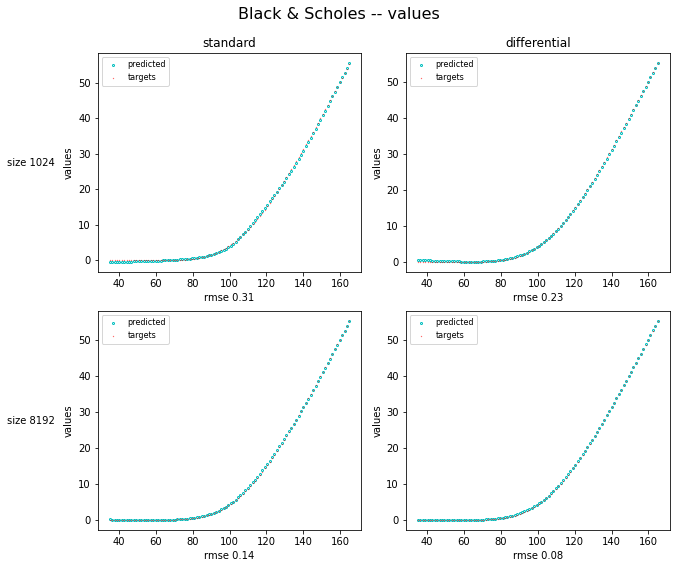

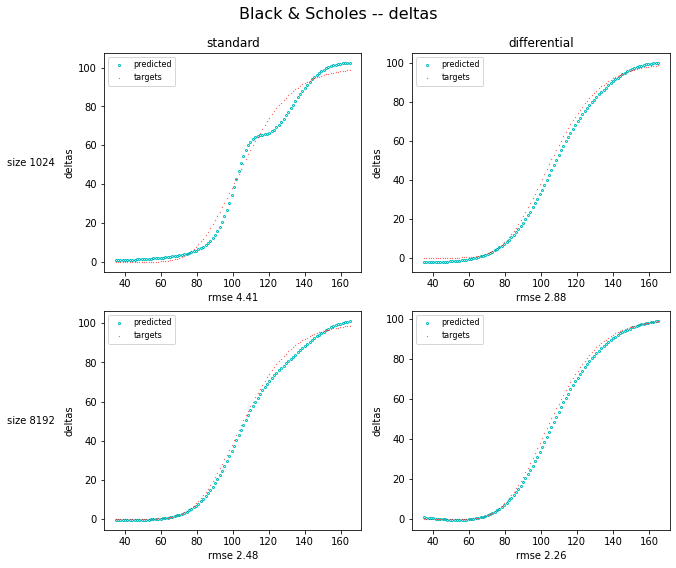

In [13]:
# show predicitions
graph("Black & Scholes", values, xAxis, "", "values", yTest, sizes, True)

# show deltas
graph("Black & Scholes", deltas, xAxis, "", "deltas", dydxTest, sizes, True)

## Gaussian basket options

We turn to the case of Bachelier basket options, keeping the original generator again:

In [14]:
# helper analytics
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return  vol * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / np.sqrt(T)
    return np.sqrt(T) * norm.pdf(d)
#
    
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])
#

class Bachelier:
    
    def __init__(self, 
                 n,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.n = n
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                
    # training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
    def trainingSet(self, m, anti=True, seed=None, bktVol=0.2):
    
        np.random.seed(seed)

        # spots all currently 1, without loss of generality
        self.S0 = np.repeat(1., self.n)
        # random correl
        self.corr = genCorrel(self.n)

        # random weights
        self.a = np.random.uniform(low=1., high=10., size=self.n)
        self.a /= np.sum(self.a)
        # random vols
        vols = np.random.uniform(low=5., high = 50., size = self.n)
        # normalize vols for a given volatility of basket, 
        # helps with charts without loss of generality
        avols = (self.a * vols).reshape((-1,1))
        v = np.sqrt(np.linalg.multi_dot([avols.T, self.corr, avols]).reshape(1))
        self.vols = vols * bktVol / v
        self.bktVol = bktVol

        # Choleski etc. for simulation
        diagv = np.diag(self.vols)
        self.cov = np.linalg.multi_dot([diagv, self.corr, diagv])
        self.chol = np.linalg.cholesky(self.cov) * np.sqrt(self.T2 - self.T1)
        # increase vols for simulation of X so we have more samples in the wings
        self.chol0 = self.chol * self.volMult * np.sqrt(self.T1 / (self.T2 - self.T1))
        # simulations
        normals = np.random.normal(size=[2, m, self.n])
        inc0 = normals[0, :, :] @ self.chol0.T
        inc1 = normals[1, :, :] @ self.chol.T
    
        S1 = self.S0 + inc0
        
        S2 = S1 + inc1
        bkt2 = np.dot(S2, self.a)
        pay = np.maximum(0, bkt2 - self.K)

        # two antithetic paths
        if anti:
            
            S2a = S1 - inc1
            bkt2a = np.dot(S2a, self.a)
            paya = np.maximum(0, bkt2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            # differentials
            Z1 =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z2 =  np.where(bkt2a > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            Z = 0.5 * (Z1 + Z2)
                    
        # standard
        else:
        
            X = S1
            Y = pay
            
            # differentials
            Z =  np.where(bkt2 > self.K, 1.0, 0.0).reshape((-1,1)) * self.a.reshape((1,-1))
            
        return X, Y.reshape(-1,1), Z
    
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas
    def testSet(self, lower=0.5, upper=1.50, num=4096, seed=None):
        
        np.random.seed(seed)
        # adjust lower and upper for dimension
        adj = 1 + 0.5 * np.sqrt((self.n-1)*(upper-lower)/12)
        adj_lower = 1.0 - (1.0-lower) * adj
        adj_upper = 1.0 + (upper - 1.0) * adj
        # draw spots
        spots = np.random.uniform(low=adj_lower, high = adj_upper, size=(num, self.n))
        # compute baskets, prices, deltas and vegas
        baskets = np.dot(spots, self.a).reshape((-1, 1))
        prices = bachPrice(baskets, self.K, self.bktVol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bachDelta(baskets, self.K, self.bktVol, self.T2 - self.T1) @ self.a.reshape((1, -1))
        vegas = bachVega(baskets, self.K, self.bktVol, self.T2 - self.T1) 
        return spots, baskets, prices, deltas, vegas    

Results in 1D: as expected, this is very similar to Black Scholes

In [15]:
# basket / bachelier dimension
basketDim = 1

# simulation set sizes to perform
sizes = [1024, 8192]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 3303
simulating training, valid and test sets
done
initializing neural appropximator
done

size 1024

size 8192


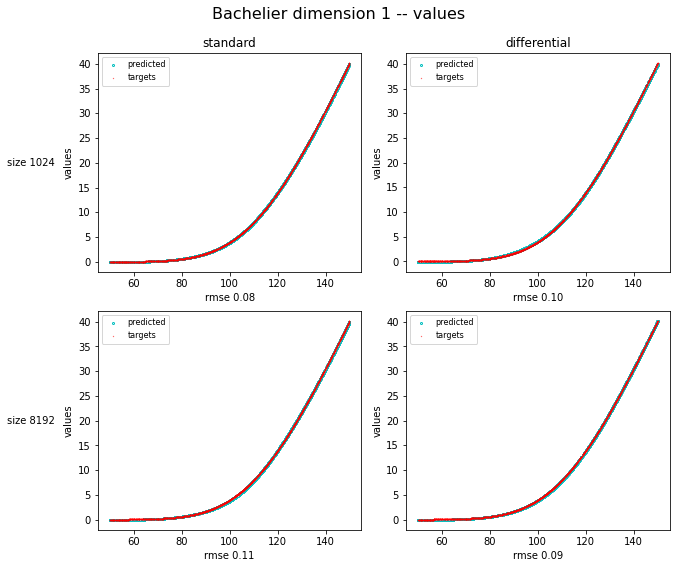

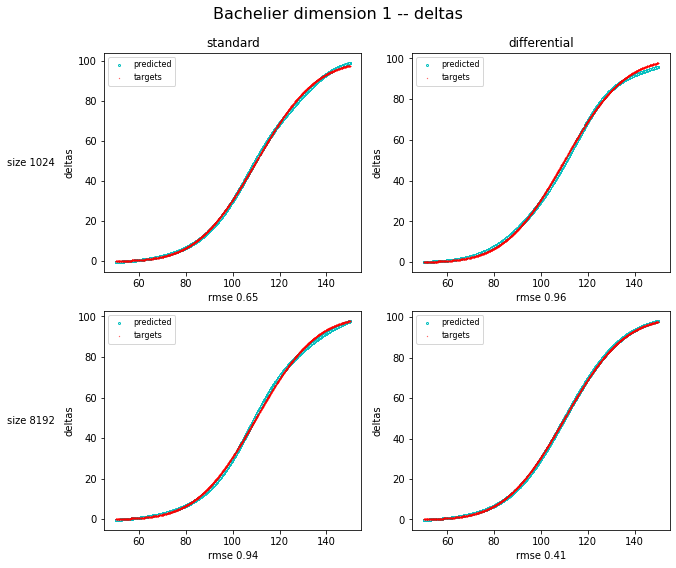

In [16]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

Now in dimension 7, still using original code on our reimplementation of Neural_Approxiator:

In [17]:
# basket / bachelier dimension
basketDim = 7

# simulation set sizes to perform
sizes = [4096, 8192, 16384]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 5917
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096

size 8192

size 16384


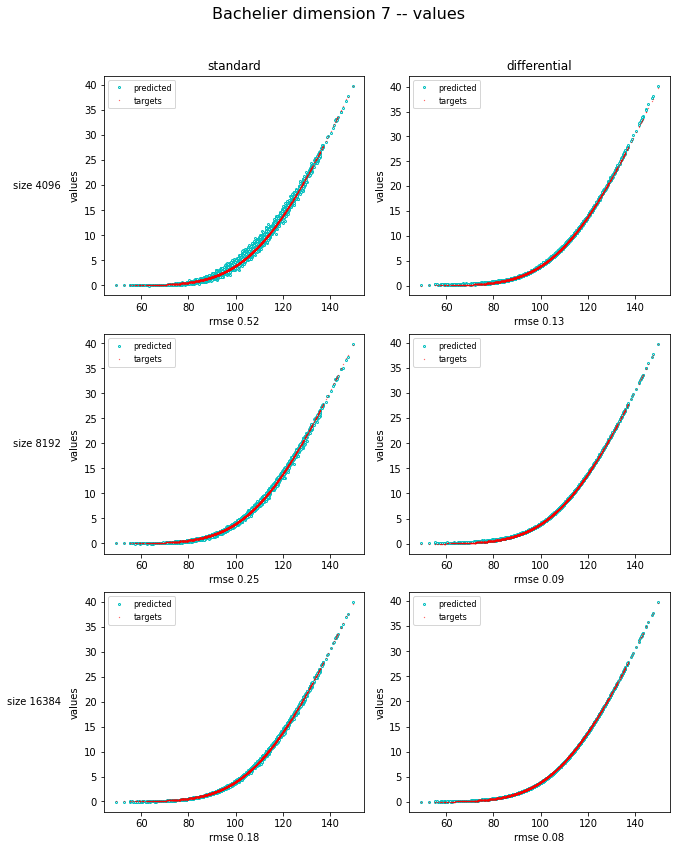

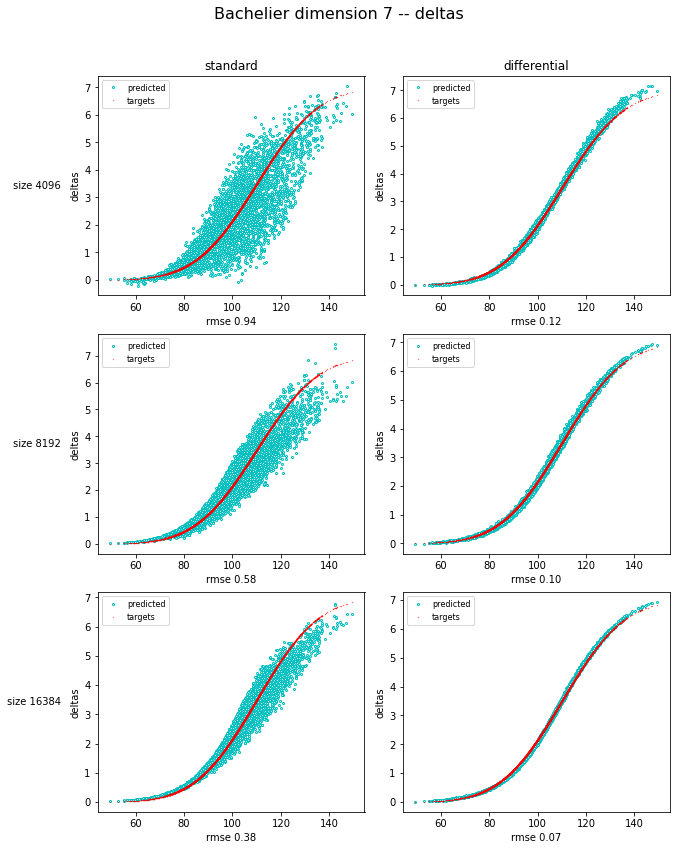

In [18]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

Moving on to dimension 20:

In [19]:
# basket / bachelier dimension
basketDim = 20

# simulation set sizes to perform
sizes = [4096, 8192, 16384]

# show delta?
showDeltas = True
deltidx = 0 # show delta to first stock

# seed
# simulSeed = 1234
simulSeed = np.random.randint(0, 10000) 
print("using seed %d" % simulSeed)
testSeed = None
weightSeed = None
    
# number of test scenarios
nTest = 4096    

# go
generator = Bachelier(basketDim)
xAxis, yTest, dydxTest, vegas, values, deltas = \
    test(generator, sizes, nTest, simulSeed, None, weightSeed)

using seed 3499
simulating training, valid and test sets
done
initializing neural appropximator
done

size 4096

size 8192

size 16384


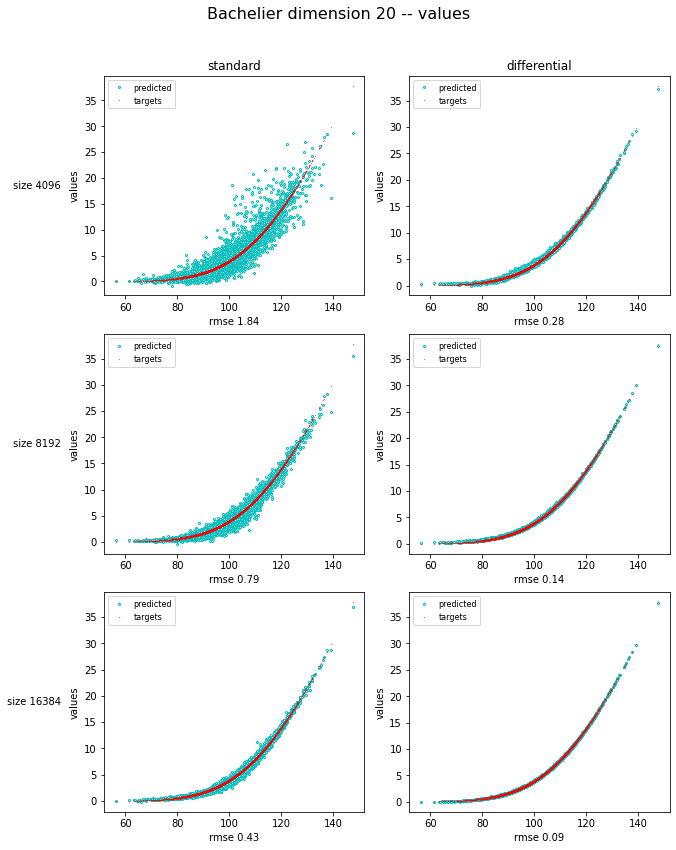

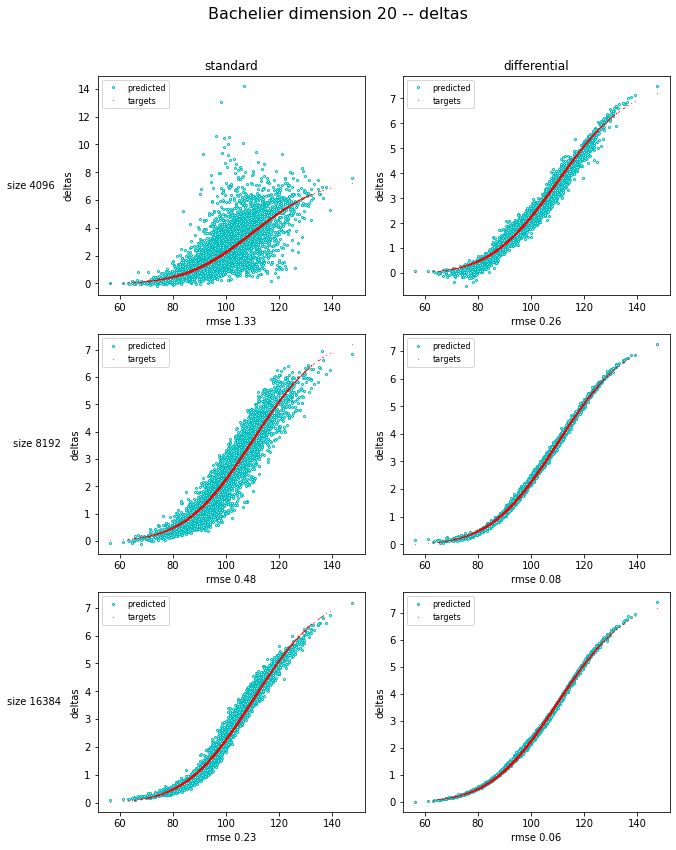

In [20]:
# show predicitions
graph("Bachelier dimension %d" % basketDim, values, xAxis, "", "values", yTest, sizes, True)

# show deltas
if showDeltas:
    graph("Bachelier dimension %d" % basketDim, deltas, xAxis, "", "deltas", dydxTest, sizes, True)

# Conclusion

We successfully replicated the author's results using modern, high-level APIs in TensorFlow 2. 
Our implementation is very generic, as any network of any number of inputs and outputs can be extended to its twin version. Possible applications include the use of bigger architectures, supported by overtiffing mitigation techniques like L1-L2 regularization, dropout, or batch normalization.

While the original paper relies on simple networks, that correspond to the Sequential API in Keras, any [DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers could be used. In particular, [residual networks](https://arxiv.org/abs/1512.03385) come to mind, with their ability to perfectly fit linear functions of their inputs, as observed when pricing deep in-the-money options.